Hello!

For many R users, This kernel has been converted from Python to R.

I referenced this kernel. https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

I am still not enough, but I will try hard.

# Introduction: Home Credit Default Risk Competition

This notebook is intended for those who are new to machine learning competitions or want a gentle introduction to the problem. I purposely avoid jumping into complicated models or joining together lots of data in order to show the basics of how to get started in machine learning! Any comments or suggestions are much appreciated.

In this notebook, we will take an initial look at the Home Credit default risk machine learning competition currently hosted on Kaggle. The objective of this competition is to use historical loan application data to predict whether or not an applicant will be able to repay a loan. This is a standard supervised classification task:

* Supervised: The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features

* Classification: The label is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying loan)

# Data
The data is provided by Home Credit, a service dedicated to provided lines of credit (loans) to the unbanked population. Predicting whether or not a client will repay a loan or have difficulty is a critical business need, and Home Credit is hosting this competition on Kaggle to see what sort of models the machine learning community can develop to help them in this task.

There are 7 different sources of data:

* application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature **SK_ID_CURR**. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.

* bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.

* bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.

* previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature **SK_ID_PREV**.

* POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.

* credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.

* installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

# Imports

In [1]:
library(data.table) # Fast CSV read
library(tidyverse)    #Visualisation
library(caret) #Cross vaildation
library(xgboost) #Xgboost
library(lightgbm) #Lightgbm
library(DataExplorer)
library(knitr)
library(gridExtra)
library(scales)
library(reshape2)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1.9000     ✔ purrr   0.3.2     
✔ tibble  2.1.1          ✔ dplyr   0.8.1     
✔ tidyr   0.8.3          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.4.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift

The following object is masked from ‘package:httr’:

    progress


Attaching package: ‘xgboost’

The following object is masked from ‘package:dplyr’:

    slice

Loading required package: R6

Attaching package: ‘lightgbm’

The following objects are m

In [2]:
# bbalance <- fread("../input/bureau_balance.csv", na.strings=c("NA","NaN","?", "","XNA"))
# bureau <- fread("../input/bureau.csv", na.strings=c("NA","NaN","?", "","XNA"))
# credit <- fread("../input/credit_card_balance.csv", na.strings=c("NA","NaN","?", "","XNA"))
# install <- fread("../input/installments_payments.csv", na.strings=c("NA","NaN","?", "","XNA")) 
# pos <- fread("../input/POS_CASH_balance.csv", na.strings=c("NA","NaN","?", "","XNA"))
# previous <- fread("../input/previous_application.csv", na.strings=c("NA","NaN","?", "","XNA"))
train <- fread("../input/application_train.csv", na.strings=c("NA","NaN","?", "","XNA")) 
test <- fread("../input/application_test.csv", na.strings=c("NA","NaN","?", "","XNA"))

In [3]:
cat("application_train : (" , nrow(train) , "," , ncol(train) , ")\n")
cat("application_test : (" , nrow(test) , "," , ncol(test) , ")")

application_train : ( 307511 , 122 )
application_test : ( 48744 , 121 )

The training data has 307511 observations (each one a separate loan) and 122 features (variables) 
including the TARGET (the label we want to predict).

The test set is considerably smaller and lacks a TARGET column.

# Exploratory Data Analysis

In [4]:
train  %>% count(TARGET)

TARGET,n
<int>,<int>
0,282686
1,24825


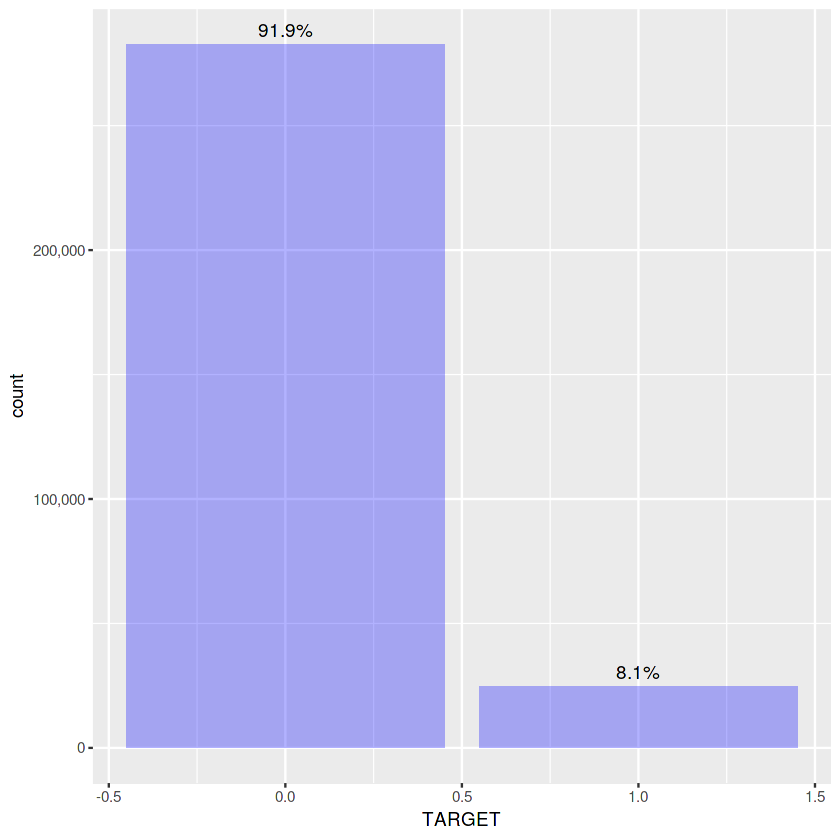

In [5]:
ggplot(train,aes(TARGET))+
    geom_bar(fill = "blue",alpha=0.3)+
    geom_text(aes(label =scales::percent(..count../sum(..count..))),stat = 'count',vjust = -0.5)+
    scale_y_continuous(label = comma) 

From this information, we see this is an imbalanced class problem. There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can weight the classes by their representation in the data to reflect this imbalance.

## Examine Missing Values

In [6]:
a=colnames(train)
b=colSums(is.na(train))  %>% as.data.table

missing_value_table=cbind(a,b)

colnames(missing_value_table)=c("variables","Missing_values")

missing_value_table = missing_value_table  %>% filter(Missing_values>0)  %>% 
                        mutate("% of Total Values" = round(100 * (Missing_values / nrow(train)),1))  %>% 
                        arrange(desc(Missing_values))

In [7]:
cat("Your selected dataframe has" , ncol(train) , " columns.\n")
cat("There are" , nrow(missing_value_table) , "columns that have missing values.")

Your selected dataframe has 122  columns.
There are 69 columns that have missing values.

In [8]:
head(missing_value_table,20)

variables,Missing_values,% of Total Values
<chr>,<dbl>,<dbl>
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_MEDI,214865,69.9
NONLIVINGAPARTMENTS_AVG,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MODE,210199,68.4


When it comes time to build our machine learning models, we will have to fill in these missing values (known as imputation). In later work, we will use models such as XGBoost that can handle missing values with no need for imputation. Another option would be to drop columns with a high percentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model. Therefore, we will keep all of the columns for now.

# Column Types

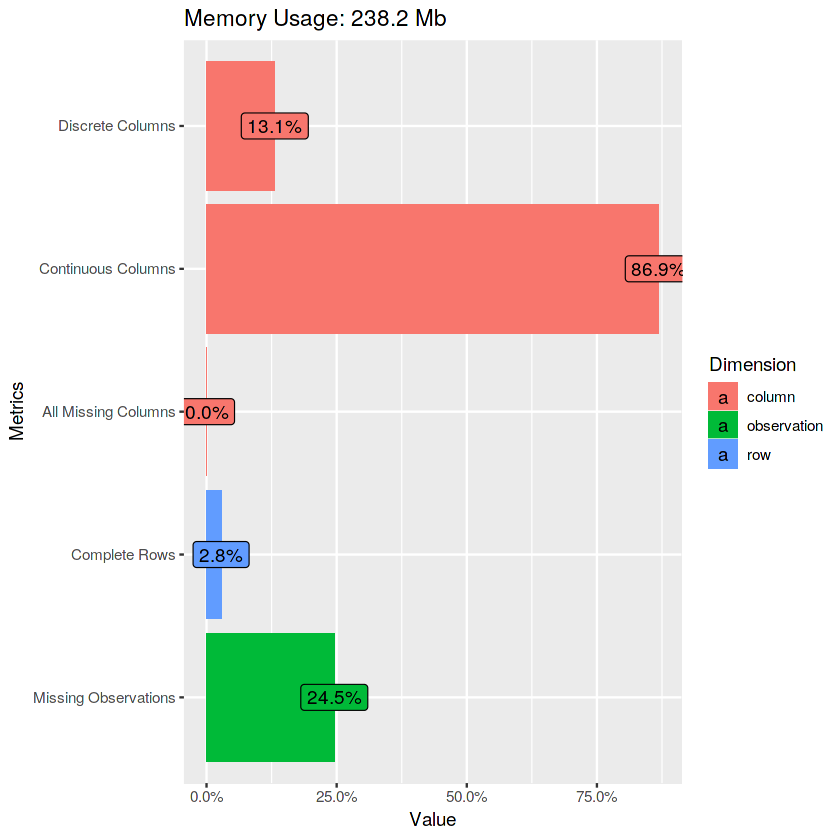

In [9]:
plot_intro(train)

In [10]:
train=train  %>% mutate_if(is.character, list(~factor(.)))
test=test  %>% mutate_if(is.character, list(~factor(.)))

In [11]:
train=train  %>% mutate_if(is.integer, list(~as.numeric(.)))
test=test  %>% mutate_if(is.integer, list(~as.numeric(.)))

In [12]:
train  %>% select_if(is.factor)  %>% summarise_all(n_distinct)  %>% t()

NAME_CONTRACT_TYPE,2
CODE_GENDER,3
FLAG_OWN_CAR,2
FLAG_OWN_REALTY,2
NAME_TYPE_SUITE,8
NAME_INCOME_TYPE,8
NAME_EDUCATION_TYPE,5
NAME_FAMILY_STATUS,6
NAME_HOUSING_TYPE,6
OCCUPATION_TYPE,19
WEEKDAY_APPR_PROCESS_START,7


CODE_GENDER, EMERGENCYSTATE_MODE colums has 3 unique values because columns are contain NA. 

Above columns have 2 unique values expect NA

Most of the categorical variables have a relatively small number of unique entries. 

We will need to find a way to deal with these categorical variables!

### Label Encoding and One-Hot Encoding
Let's implement the policy described above: for any categorical variable (dtype == object) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding.

In [13]:
# Label Encoding
# We only have 2 unique value colums: NAME_CONTRACT_TYPE, FLAG_OWN_CAR, FLAG_OWN_REALTY, CODE_GENDER, EMERGENCYSTATE_MODE

unique2_col = c('NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CODE_GENDER', 'EMERGENCYSTATE_MODE')

str(train[,unique2_col])

'data.frame':	307511 obs. of  5 variables:
 $ NAME_CONTRACT_TYPE : Factor w/ 2 levels "Cash loans","Revolving loans": 1 1 2 1 1 1 1 1 1 2 ...
 $ FLAG_OWN_CAR       : Factor w/ 2 levels "N","Y": 1 1 2 1 1 1 2 2 1 1 ...
 $ FLAG_OWN_REALTY    : Factor w/ 2 levels "N","Y": 2 1 2 2 2 2 2 2 2 2 ...
 $ CODE_GENDER        : Factor w/ 2 levels "F","M": 2 1 2 1 2 2 1 2 1 2 ...
 $ EMERGENCYSTATE_MODE: Factor w/ 2 levels "No","Yes": 1 1 NA NA NA NA NA NA NA NA ...


In [14]:
for (i in unique2_col)
{    
    train[,i]=as.numeric(train[,i])
    test[,i]=as.numeric(test[,i])
}

In [15]:
# one-hot encoding of categorical variables

dmy <- dummyVars(" ~ .", data = train)
train <- data.frame(predict(dmy, newdata = train))

dmy2 <- dummyVars(" ~ .", data = test)
test <- data.frame(predict(dmy2, newdata = test))

In [16]:
cat('Training Features shape: (', nrow(train),',', ncol(train), ')\n')
cat('Training Features shape: (', nrow(test),',', ncol(test), ')')

Training Features shape: ( 307511 , 239 )
Training Features shape: ( 48744 , 236 )

### Aligning Training and Testing Data

There need to be the same features (columns) in both the training and testing data. 

One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. 

To remove the columns in the training data that are not in the testing data, we need to align the dataframes.

First we extract the target column from the training data (because this is not in the testing data but we need to keep this information). 

In [17]:
train_labels=train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
align = intersect(colnames(train),colnames(test))

train = train[,align]
test = test[,align]

In [18]:
# Add the target back in

train=bind_cols(train_labels,train)

In [19]:
cat('Training Features shape: (', nrow(train),',', ncol(train), ')\n')
cat('Training Features shape: (', nrow(test),',', ncol(test), ')')

Training Features shape: ( 307511 , 237 )
Training Features shape: ( 48744 , 236 )

# Back to Exploratory Data Analysis

In [20]:
summary(train[,'DAYS_BIRTH'])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -25229  -19682  -15750  -16037  -12413   -7489 

One problem we always want to be on the lookout for when doing EDA is anomalies within the data. 

These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. 

One way to support anomalies quantitatively is by looking at the statistics of a column using the describe method. 

The numbers in the DAYS_BIRTH column are negative because they are recorded relative to the current loan application. 

To see these stats in years, we can mutliple by -1 and divide by the number of days in a year

In [21]:
summary(train[,'DAYS_BIRTH'] /-365)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  20.52   34.01   43.15   43.94   53.92   69.12 

Those ages look reasonable. There are no outliers for the age on either the high or low end. How about the days of employment?

In [22]:
summary(train[,'DAYS_EMPLOYED'])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -17912   -2760   -1213   63815    -289  365243 

That doesn't look right! The maximum value (besides being positive) is about 1000 years!

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


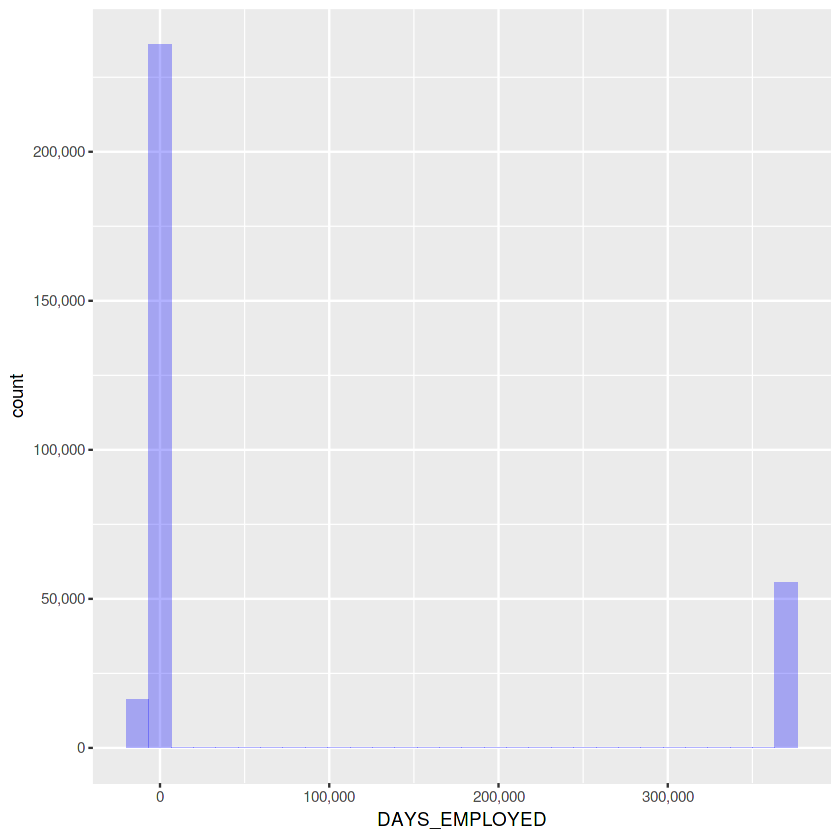

In [23]:
ggplot(train,aes(DAYS_EMPLOYED))+
    geom_histogram(fill = "blue",alpha=0.3)+
    scale_x_continuous(label = comma)+
    scale_y_continuous(label = comma) 

In [24]:
anom= train  %>% filter(DAYS_EMPLOYED==365243)
non_anom= train %>% filter(DAYS_EMPLOYED!=365243)

sprintf('The non-anomalies default on %0.2f%% of loans' , (100 * mean(non_anom[,'TARGET'])) )
sprintf('The anomalies default on %0.2f%% of loans' , (100 * mean(anom[,'TARGET'])) )
sprintf('There are %d anomalous days of employment' , nrow(anom) )

[1] "The non-anomalies default on 8.66% of loans"

[1] "The anomalies default on 5.40% of loans"

[1] "There are 55374 anomalous days of employment"

Well that is extremely interesting! It turns out that the anomalies have a lower rate of default.

Handling the anomalies depends on the exact situation, with no set rules. 

One of the safest approaches is just to set the anomalies to a missing value and then have them filled in (using Imputation) before machine learning. 

In this case, since all the anomalies have the exact same value, we want to fill them in with the same value in case all of these loans share something in common. 

The anomalous values seem to have some importance, so we want to tell the machine learning model if we did in fact fill in these values. 

As a solution, we will fill in the anomalous values with not a number (np.nan) and then create a new boolean column indicating whether or not the value was anomalous.

In [25]:
# Create an anomalous flag column
train=train  %>% mutate('DAYS_EMPLOYED_ANOM' = ifelse(DAYS_EMPLOYED == c(365243),1,0),
                        # Replace the anomalous values with nan
                        'DAYS_EMPLOYED'= ifelse(DAYS_EMPLOYED == c(365243), NA, DAYS_EMPLOYED)
                       )

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 55374 rows containing non-finite values (stat_bin).”

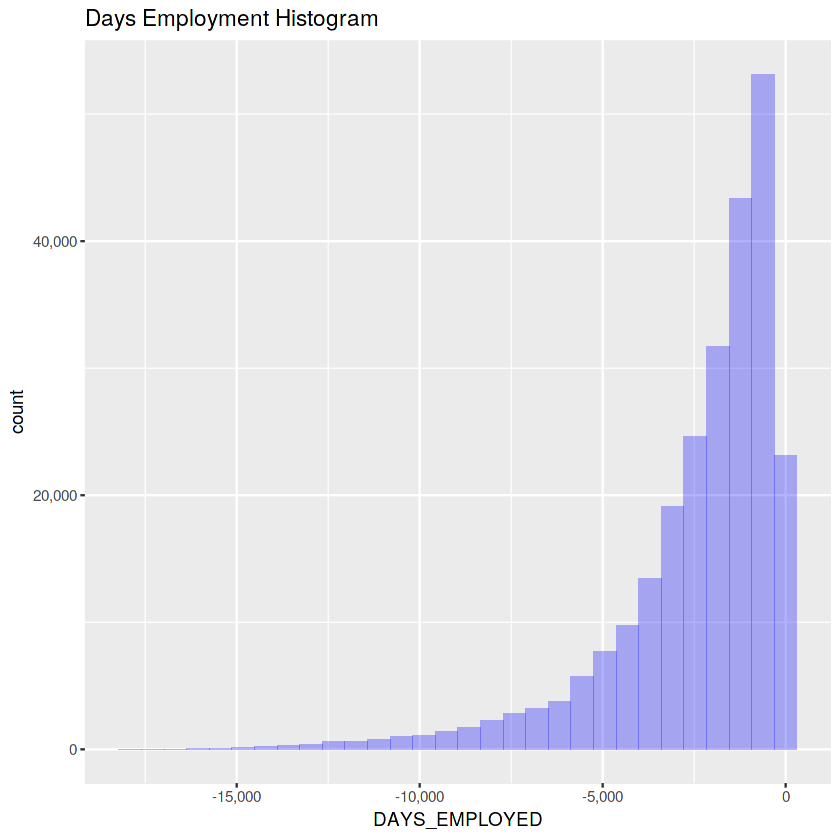

In [26]:
ggplot(train,aes(DAYS_EMPLOYED))+
    geom_histogram(fill = "blue",alpha=0.3)+
    scale_x_continuous(label = comma)+
    scale_y_continuous(label = comma)+
    ggtitle("Days Employment Histogram")

The distribution looks to be much more in line with what we would expect, and we also have created a new column to tell the model that these values were originally anomalous (becuase we will have to fill in the nans with some value, probably the median of the column). 

The other columns with DAYS in the dataframe look to be about what we expect with no obvious outliers.

As an extremely important note, anything we do to the training data we also have to do to the testing data. 

Let's make sure to create the new column and fill in the existing column with np.nan in the testing data.

In [27]:
summary(test$'DAYS_EMPLOYED')

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -17463   -2910   -1293   67485    -296  365243 

In [28]:
# Create an anomalous flag column
test=test  %>% mutate('DAYS_EMPLOYED_ANOM' = ifelse(DAYS_EMPLOYED == c(365243),1,0),
                        # Replace the anomalous values with nan
                        'DAYS_EMPLOYED'= ifelse(DAYS_EMPLOYED == c(365243), NA, DAYS_EMPLOYED)
                       )

sprintf('There are %d anomalies in the test data out of %d entries' ,sum(test["DAYS_EMPLOYED_ANOM"]), nrow(test) )

[1] "There are 9274 anomalies in the test data out of 48744 entries"

### Correlations
Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA.

One way to try and understand the data is by looking for correlations between the features and the target. 

We can calculate the Pearson correlation coefficient between every variable and the target using the .corr dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficent are:

> .00-.19 “very weak”
> 
> .20-.39 “weak”
> 
> .40-.59 “moderate”
> 
> .60-.79 “strong”
> 
> .80-1.0 “very strong”

In [29]:
res=cor(train, train$TARGET, method = "pearson", use = "pairwise")  %>% as.data.frame

In [30]:
a=colnames(train)

correlations=cbind(a,res)
correlations  %>% arrange(desc(V1))  %>% head(15)

a,V1
<fct>,<dbl>
TARGET,1.00000000
DAYS_BIRTH,0.07823931
DAYS_EMPLOYED,0.07495846
REGION_RATING_CLIENT_W_CITY,0.06089267
REGION_RATING_CLIENT,0.05889901
NAME_INCOME_TYPE.Working,0.05748118
DAYS_LAST_PHONE_CHANGE,0.05521848
CODE_GENDER,0.05471012
DAYS_ID_PUBLISH,0.05145717


In [31]:
correlations  %>% arrange(desc(V1))  %>% tail(15)

,a,V1
,<fct>,<dbl>
224,FLOORSMIN_AVG,-0.03361350
225,ELEVATORS_MEDI,-0.03386288
226,OCCUPATION_TYPE.Core.staff,-0.03396877
227,ELEVATORS_AVG,-0.03419879
228,REGION_POPULATION_RELATIVE,-0.03722715
229,AMT_GOODS_PRICE,-0.03964528
230,FLOORSMAX_MODE,-0.04322626
231,FLOORSMAX_MEDI,-0.04376792
232,FLOORSMAX_AVG,-0.04400337


Let's take a look at some of more significant correlations: the DAYS_BIRTH is the most positive correlation. 
(except for  TARGET because the correlation of a variable with itself is always 1!) 

Looking at the documentation, DAYS_BIRTH is the age in days of the client at the time of the loan in negative days (for whatever reason!). 

The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, they are less likely to default on their loan (ie the target == 0). 

That's a little confusing, so we will take the absolute value of the feature and then the correlation will be negative.

### Effect of Age on Repayment

In [32]:
train[,'DAYS_BIRTH'] = abs(train[,'DAYS_BIRTH'])

cor(train[,'DAYS_BIRTH'],train[,'TARGET'])

[1] -0.07823931

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often.

Let's start looking at this variable. First, we can make a histogram of the age. We will put the x axis in years to make the plot a little more understandable

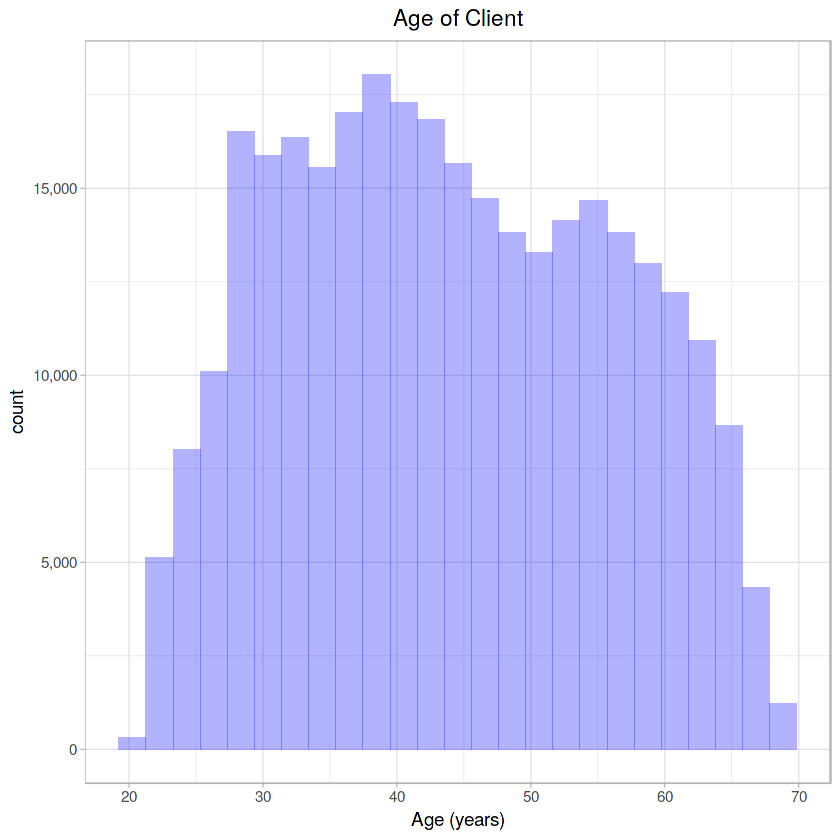

In [33]:
ggplot(train, aes(DAYS_BIRTH /365))+
    geom_histogram(fill = "blue",alpha=0.3,bins = 25)+
    scale_x_continuous(label = comma)+
    scale_y_continuous(label = comma)+
    theme_light() + 
    labs(title = "Age of Client", x = "Age (years)")+
    theme(plot.title = element_text(hjust = .5))

By itself, the distribution of age does not tell us much other than that there are no outliers as all the ages are reasonable. 

To visualize the effect of the age on the target, we will next make a kernel density estimation plot (KDE) colored by the value of the target. 

A kernel density estimate plot shows the distribution of a single variable and can be thought of as a smoothed histogram (it is created by computing a kernel, usually a Gaussian, at each data point and then averaging all the individual kernels to develop a single smooth curve). 

We will use the ggplot kdeplot for this graph.

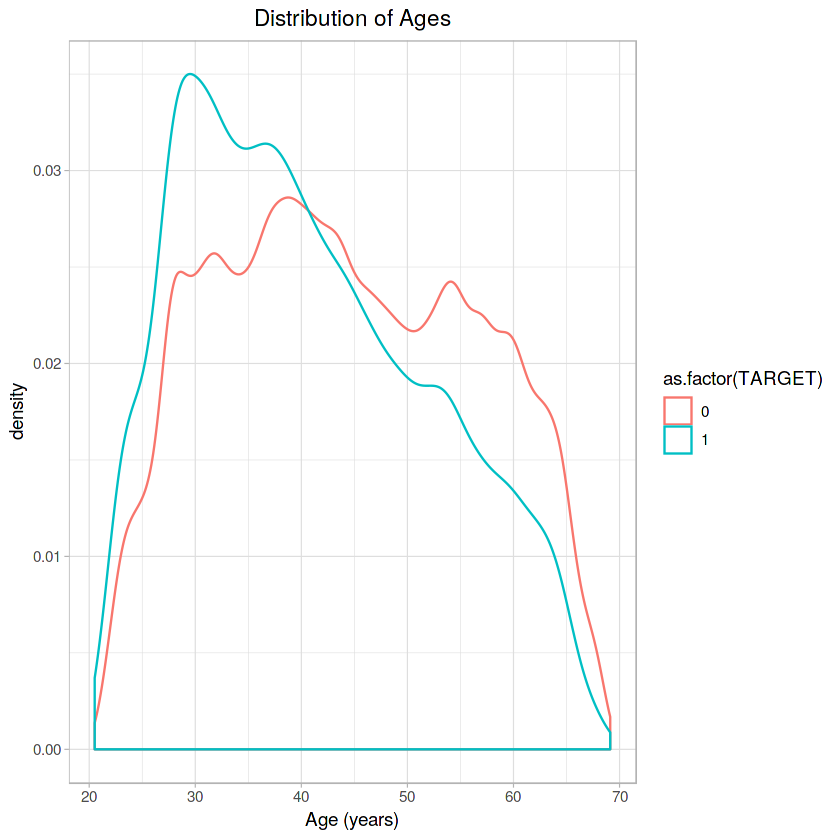

In [34]:
ggplot(train, aes(DAYS_BIRTH /365,colour=as.factor(TARGET),group=as.factor(TARGET)))+
    geom_density()+
    scale_x_continuous(label = comma)+
    scale_y_continuous()+
    theme_light() + 
    labs(title = "Distribution of Ages", x = "Age (years)")+
    theme(plot.title = element_text(hjust = .5))

The target == 1 curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. 

Let's look at this relationship in another way: average failure to repay loans by age bracket.

To make this graph, first we cut the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [35]:
# Age information into a separate dataframe
age_data= train  %>% select('TARGET', 'DAYS_BIRTH')  %>% 
            mutate( YEARS_BIRTH = DAYS_BIRTH / 365)

# Bin the age data
age_data[,'YEARS_BINNED'] = cut(age_data[,'YEARS_BIRTH'], breaks = seq(20,70,by=5))
head(age_data,10)

TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
<dbl>,<dbl>,<dbl>,<fct>
1,9461,25.92055,"(25,30]"
0,16765,45.93151,"(45,50]"
0,19046,52.18082,"(50,55]"
0,19005,52.06849,"(50,55]"
0,19932,54.60822,"(50,55]"
0,16941,46.41370,"(45,50]"
0,13778,37.74795,"(35,40]"
0,18850,51.64384,"(50,55]"
0,20099,55.06575,"(55,60]"


In [36]:
# Group by the bin and calculate averages
age_data  %>% group_by(YEARS_BINNED)  %>% summarise_all(mean)

YEARS_BINNED,TARGET,DAYS_BIRTH,YEARS_BIRTH
<fct>,<dbl>,<dbl>,<dbl>
"(20,25]",0.12303643,8532.796,23.37752
"(25,30]",0.11143570,10155.219,27.82252
"(30,35]",0.10281440,11854.848,32.47904
"(35,40]",0.08941402,13707.908,37.55591
"(40,45]",0.07849104,15497.661,42.45935
"(45,50]",0.07417105,17323.900,47.46274
"(50,55]",0.06696812,19196.495,52.59314
"(55,60]",0.05531401,20984.263,57.49113
"(60,65]",0.05273693,22780.547,62.41246


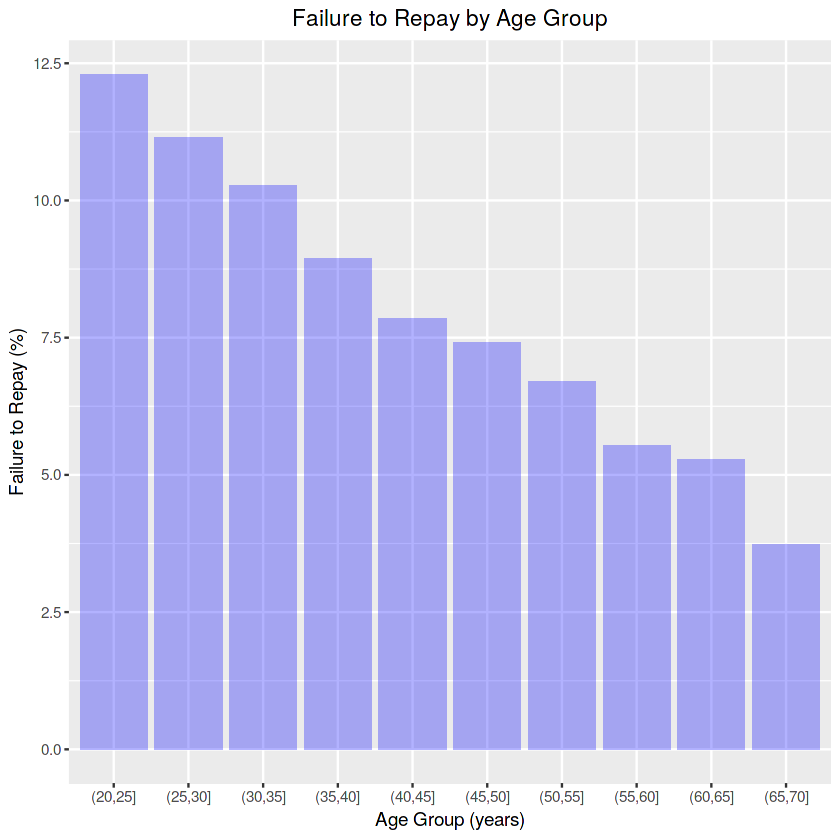

In [37]:
age_data  %>% group_by(YEARS_BINNED)  %>% summarise_all(mean)  %>% 
    ggplot(aes(x=YEARS_BINNED, y=TARGET*100))+
        geom_col(fill = "blue",alpha=0.3)+
        labs(title = "Failure to Repay by Age Group", x = "Age Group (years)", y= 'Failure to Repay (%)')+
        theme(plot.title = element_text(hjust = .5))

There is a clear trend: younger applicants are more likely to not repay the loan! 

The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

### Exterior Sources
The 3 variables with the strongest negative correlations with the target are EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3.

According to the documentation, these features represent a "normalized score from external data source". 

I'm not sure what this exactly means, but it may be a cumulative sort of credit rating made using numerous sources of data.

Let's take a look at these variables.

First, we can show the correlations of the EXT_SOURCE features with the target and with each other.

In [38]:
ext_data = train[,c('TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH')]
ext_data_corrs = cor(ext_data, use = "pairwise")
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.00000000,-0.1553171,-0.16047167,-0.1789187,-0.07823931
EXT_SOURCE_1,-0.15531713,1.0000000,0.21398238,0.1868455,0.60060997
EXT_SOURCE_2,-0.16047167,0.2139824,1.00000000,0.1091673,0.09199587
EXT_SOURCE_3,-0.17891870,0.1868455,0.10916729,1.0000000,0.20547760
DAYS_BIRTH,-0.07823931,0.6006100,0.09199587,0.2054776,1.00000000


In [39]:
melted_cormat <- melt(ext_data_corrs,na.rm=TRUE)
head(melted_cormat)

Var1,Var2,value
<fct>,<fct>,<dbl>
TARGET,TARGET,1.00000000
EXT_SOURCE_1,TARGET,-0.15531713
EXT_SOURCE_2,TARGET,-0.16047167
EXT_SOURCE_3,TARGET,-0.17891870
DAYS_BIRTH,TARGET,-0.07823931
TARGET,EXT_SOURCE_1,-0.15531713


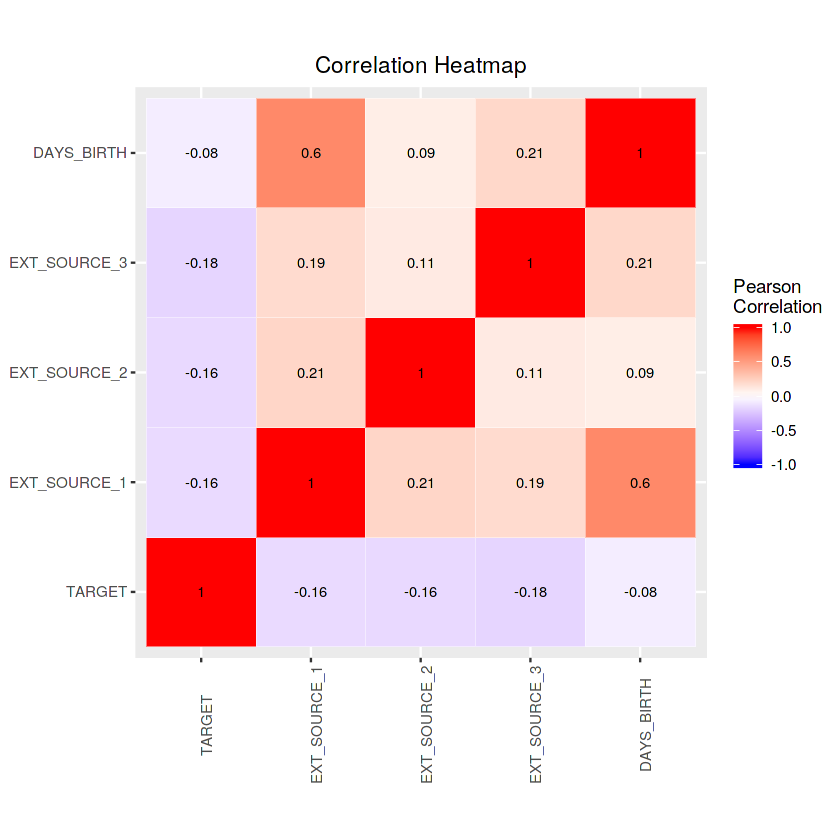

In [40]:
ggplot(data = melted_cormat, aes(x=Var1, y=Var2, fill=value)) + 
  geom_tile(color = "white")+
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", midpoint = 0, limit = c(-1,1), space = "Lab", name="Pearson\nCorrelation") +
  labs(title='Correlation Heatmap')+
  theme(plot.title = element_text(hjust = .5), axis.text.x = element_text(angle=90),
       axis.title.x=element_blank(),
       axis.title.y=element_blank())+
  coord_fixed()+
  geom_text(aes(Var2, Var1, label = round(value,2)), color = "black", size = 3)

All three EXT_SOURCE features have negative correlations with the target, indicating that as the value of the EXT_SOURCE increases, the client is more likely to repay the loan. 

We can also see that DAYS_BIRTH is positively correlated with EXT_SOURCE_1 indicating that maybe one of the factors in this score is the client age.

Next we can look at the distribution of each of these features colored by the value of the target. This will let us visualize the effect of this variable on the target.

Warning message:
“Removed 173378 rows containing non-finite values (stat_density).”Warning message:
“Removed 660 rows containing non-finite values (stat_density).”Warning message:
“Removed 60965 rows containing non-finite values (stat_density).”

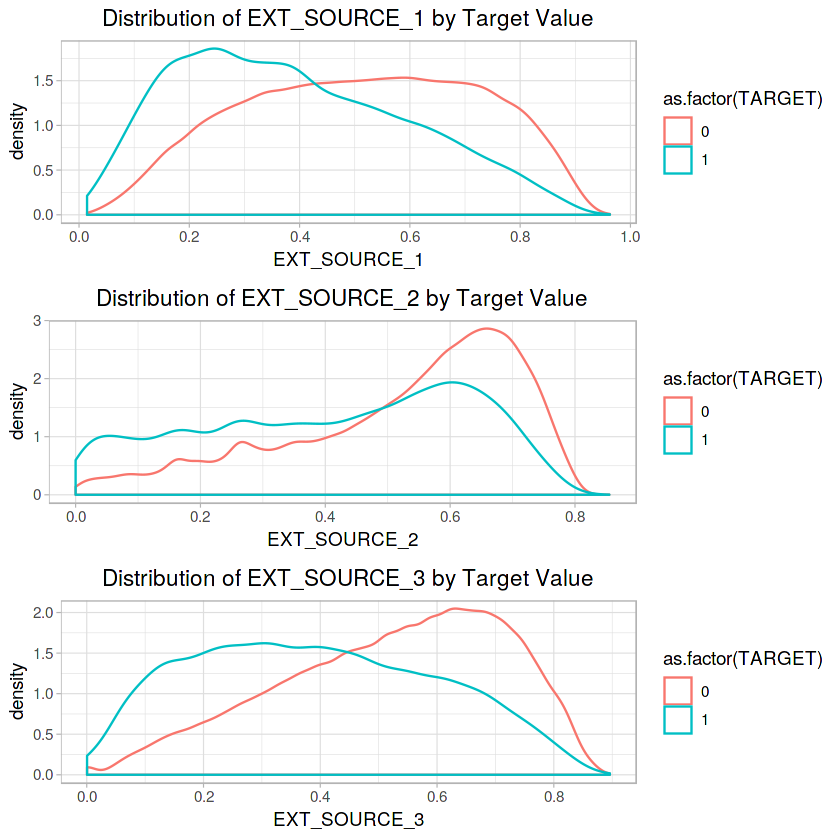

In [41]:
p1=ggplot(train, aes(EXT_SOURCE_1,colour=as.factor(TARGET),group=as.factor(TARGET)))+
    geom_density()+
    scale_x_continuous(breaks=seq(0,1,by=0.2))+
    scale_y_continuous()+
    theme_light() + 
    labs(title = "Distribution of EXT_SOURCE_1 by Target Value", x = "EXT_SOURCE_1")+
    theme(plot.title = element_text(hjust = .5))

p2=ggplot(train, aes(EXT_SOURCE_2,colour=as.factor(TARGET),group=as.factor(TARGET)))+
    geom_density()+
    scale_x_continuous(breaks=seq(0,1,by=0.2))+
    scale_y_continuous()+
    theme_light() + 
    labs(title = "Distribution of EXT_SOURCE_2 by Target Value", x = "EXT_SOURCE_2")+
    theme(plot.title = element_text(hjust = .5))

p3=ggplot(train, aes(EXT_SOURCE_3,colour=as.factor(TARGET),group=as.factor(TARGET)))+
    geom_density()+
    scale_x_continuous(breaks=seq(0,1,by=0.2))+
    scale_y_continuous()+
    theme_light() + 
    labs(title = "Distribution of EXT_SOURCE_3 by Target Value", x = "EXT_SOURCE_3")+
    theme(plot.title = element_text(hjust = .5))

grid.arrange(p1,p2,p3,nrow=3)

EXT_SOURCE_3 displays the greatest difference between the values of the target. 

We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. 

The relationship is not very strong (in fact they are all considered very weak, but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

### Pairs Plot
As a final exploratory plot, we can make a pairs plot of the EXT_SOURCE variables and the DAYS_BIRTH variable. 

The Pairs Plot is a great exploration tool because it lets us see relationships between multiple pairs of variables as well as distributions of single variables. 

Here we are using the  ggplot and gridExtra library to create a Pairs Plot with scatterplots on the upper triangle, histograms on the diagonal, and 2D kernel density plots and correlation coefficients on the lower triangle.

If you don't understand this code, that's all right! Plotting in R can be overly complex, and for anything beyond the simplest graphs, I usually find an existing implementation and adapt the code (don't repeat yourself)!

In [42]:
plot_data = ext_data  %>% select(-DAYS_BIRTH)  %>% 
                mutate(YEARS_BIRTH = age_data[,'YEARS_BIRTH'])

In [43]:
plot_data=na.omit(plot_data[1:10000,])

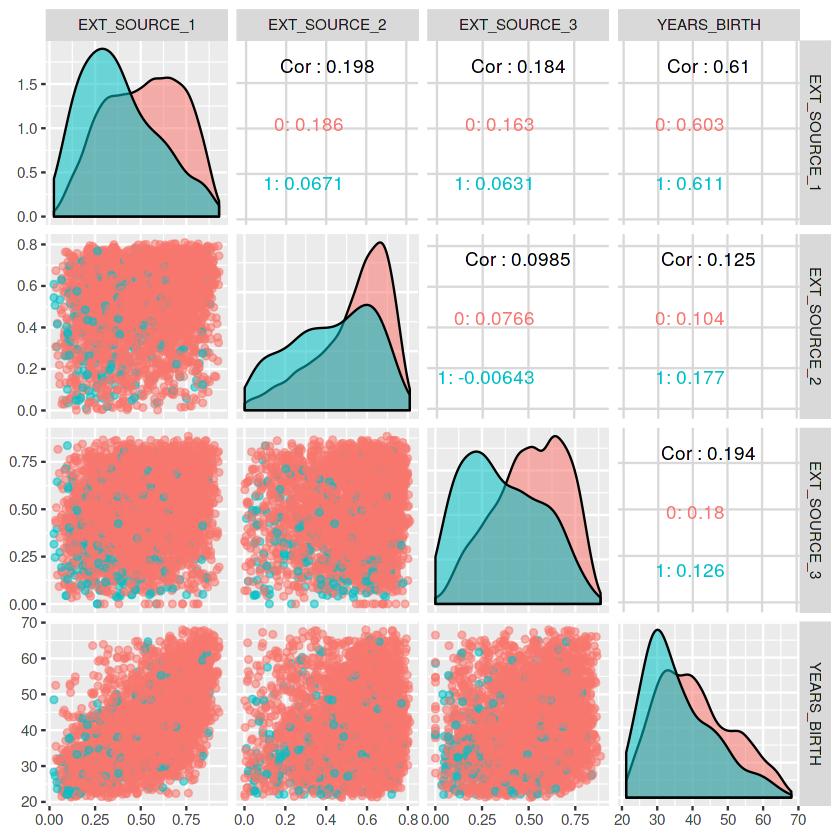

In [44]:
plt=ggpairs(data=plot_data, columns=c(2:5), aes(colour=as.factor(TARGET),group=as.factor(TARGET),alpha=0.005))
suppressWarnings(print(plt))

Sorry, I don't know how to draw ggpairs well.

In this plot, the red indicates loans that were not repaid and the blue are loans that are paid. 

We can see the different relationships within the data. 

There does appear to be a moderate positive linear relationship between the EXT_SOURCE_1 and the DAYS_BIRTH (or equivalently YEARS_BIRTH), indicating that this feature may take into account the age of the client.

# Featrue Engineering

Kaggle competitions are won by feature engineering: those win are those who can create the most useful features out of the data. 

(This is true for the most part as the winning models, at least for structured data, all tend to be variants on gradient boosting).

This represents one of the patterns in machine learning: feature engineering has a greater return on investment than model building and hyperparameter tuning. 

This is a great article on the subject). As Andrew Ng is fond of saying: "applied machine learning is basically feature engineering."

While choosing the right model and optimal settings are important, the model can only learn from the data it is given. 

Making sure this data is as relevant to the task as possible is the job of the data scientist (and maybe some automated tools to help us out).

Feature engineering refers to a geneal process and can involve both feature construction: adding new features from the existing data, and feature selection: choosing only the most important features or other methods of dimensionality reduction. There are many techniques we can use to both create features and select features.

We will do a lot of feature engineering when we start using the other data sources, but in this notebook we will try only two simple feature construction methods:

* Polynomial features
* Domain knowledge features

### Polynomial Features
One simple feature construction method is called polynomial features. In this method, we make features that are powers of existing features as well as interaction terms between existing features. 

For example, we can create variables EXT_SOURCE_1^2 and EXT_SOURCE_2^2 and also variables such as EXT_SOURCE_1 x EXT_SOURCE_2, EXT_SOURCE_1 x EXT_SOURCE_2^2, EXT_SOURCE_1^2 x  EXT_SOURCE_2^2, and so on. 

These features that are a combination of multiple individual variables are called interaction terms because they capture the interactions between variables. 

In other words, while two variables by themselves may not have a strong influence on the target, combining them together into a single interaction variable might show a relationship with the target. 

Interaction terms are commonly used in statistical models to capture the effects of multiple variables, but I do not see them used as often in machine learning. 

Nonetheless, we can try out a few to see if they might help our model to predict whether or not a client will repay a loan.

In the following code, we create polynomial features using the EXT_SOURCE variables and the DAYS_BIRTH variable.

We can use a degree of 3 to see the results (when we are creating polynomial features, we want to avoid using too high of a degree, both because the number of features scales exponentially with the degree, and because we can run into problems with overfitting).

In [45]:
# Make a new dataframe for polynomial features
poly_features = train[,c('EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET')]
poly_features_test = test[,c('EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH')]

# imputer for handling missing values
poly_features = sapply(poly_features, function(x) ifelse(is.na(x), median(x, na.rm=TRUE), x))  %>% as.data.frame
poly_features_test = sapply(poly_features_test, function(x) ifelse(is.na(x), median(x, na.rm=TRUE), x))  %>% as.data.frame

In [46]:
poly_target = poly_features[,'TARGET']

In [47]:
form <- TARGET ~.^3
poly_features= model.matrix(form, data=poly_features)  %>% as.data.frame

In [48]:
str(poly_features)

'data.frame':	307511 obs. of  15 variables:
 $ (Intercept)                           : num  1 1 1 1 1 1 1 1 1 1 ...
 $ EXT_SOURCE_1                          : num  0.083 0.311 0.506 0.506 0.506 ...
 $ EXT_SOURCE_2                          : num  0.263 0.622 0.556 0.65 0.323 ...
 $ EXT_SOURCE_3                          : num  0.139 0.535 0.73 0.535 0.535 ...
 $ DAYS_BIRTH                            : num  9461 16765 19046 19005 19932 ...
 $ EXT_SOURCE_1:EXT_SOURCE_2             : num  0.0218 0.1937 0.2813 0.3291 0.1633 ...
 $ EXT_SOURCE_1:EXT_SOURCE_3             : num  0.0116 0.1666 0.3692 0.2708 0.2708 ...
 $ EXT_SOURCE_1:DAYS_BIRTH               : num  786 5218 9637 9616 10086 ...
 $ EXT_SOURCE_2:EXT_SOURCE_3             : num  0.0366 0.3331 0.4056 0.3482 0.1728 ...
 $ EXT_SOURCE_2:DAYS_BIRTH               : num  2488 10432 10588 12362 6433 ...
 $ EXT_SOURCE_3:DAYS_BIRTH               : num  1319 8974 13895 10173 10669 ...
 $ EXT_SOURCE_1:EXT_SOURCE_2:EXT_SOURCE_3: num  0.00304 0.103

In [49]:
poly_cors = cbind(poly_target,poly_features)

In [50]:
res=cor(poly_cors, poly_target, method = "pearson", use = "pairwise")

melted_res <- melt(res,na.rm=TRUE)

Warning message in cor(poly_cors, poly_target, method = "pearson", use = "pairwise"):
“the standard deviation is zero”

In [51]:
melted_res  %>% arrange(desc(value))  %>% select(Var1,value)  %>% head(10)

Var1,value
<fct>,<dbl>
poly_target,1.00000000
DAYS_BIRTH,-0.07823931
EXT_SOURCE_1,-0.09888661
EXT_SOURCE_1:DAYS_BIRTH,-0.10488218
EXT_SOURCE_3:DAYS_BIRTH,-0.15010891
EXT_SOURCE_1:EXT_SOURCE_3:DAYS_BIRTH,-0.15181592
EXT_SOURCE_1:EXT_SOURCE_2:DAYS_BIRTH,-0.15589110
EXT_SOURCE_3,-0.15589169
EXT_SOURCE_2:DAYS_BIRTH,-0.15687301


In [52]:
melted_res  %>% arrange(desc(value))  %>% select(Var1,value)  %>% tail(5)

,Var1,value
,<fct>,<dbl>
11,EXT_SOURCE_1:EXT_SOURCE_3,-0.1640653
12,EXT_SOURCE_1:EXT_SOURCE_2,-0.1666248
13,EXT_SOURCE_2:EXT_SOURCE_3:DAYS_BIRTH,-0.1812835
14,EXT_SOURCE_1:EXT_SOURCE_2:EXT_SOURCE_3,-0.1896045
15,EXT_SOURCE_2:EXT_SOURCE_3,-0.1939386


Several of the new variables have a greater (in terms of absolute magnitude) correlation with the target than the original features. When we build machine learning models, we can try with and without these features to determine if they actually help the model learn.

We will add these features to a copy of the training and testing data and then evaluate models with and without the features. Many times in machine learning, the only way to know if an approach will work is to try it out!

In [53]:
# Put test features into dataframe
form <- ~.^3
poly_features_test= model.matrix(form, data=poly_features_test)  %>% as.data.frame

In [54]:
# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = train['SK_ID_CURR']

# Merge polynomial features into test dataframe
poly_features_test['SK_ID_CURR'] = test['SK_ID_CURR']

In [55]:
# Except intercept
poly_features=poly_features  %>% select(-1)

In [56]:
train_poly= left_join(train,poly_features,by='SK_ID_CURR')
test_poly= left_join(test,poly_features_test,by='SK_ID_CURR')

In [57]:
cat("train_poly : (" , nrow(train_poly) , "," , ncol(train_poly) , ")\n")
cat("train_test : (" , nrow(test_poly) , "," , ncol(test_poly) , ")")

train_poly : ( 307511 , 252 )
train_test : ( 48744 , 252 )

### Domain Knowledge Features
Maybe it's not entirely correct to call this "domain knowledge" because I'm not a credit expert, but perhaps we could call this "attempts at applying limited financial knowledge". In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whether a client will default on a loan. Here I'm going to use five features that were inspired by this script by Aguiar:

* CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
* ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
* CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due
* DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

Again, thanks to Aguiar and his great script for exploring these features.

In [58]:
train_domain=train

train_domain[,'CREDIT_INCOME_PERCENT'] = train_domain[,'AMT_CREDIT'] / train_domain[,'AMT_INCOME_TOTAL']
train_domain[,'ANNUITY_INCOME_PERCENT'] = train_domain[,'AMT_ANNUITY'] / train_domain[,'AMT_INCOME_TOTAL']
train_domain[,'CREDIT_TERM'] = train_domain[,'AMT_ANNUITY'] / train_domain[,'AMT_CREDIT']
train_domain[,'DAYS_EMPLOYED_PERCENT'] = train_domain[,'DAYS_EMPLOYED'] / train_domain[,'DAYS_BIRTH']

In [59]:
test_domain=train

test_domain[,'CREDIT_INCOME_PERCENT'] = test_domain[,'AMT_CREDIT'] / test_domain[,'AMT_INCOME_TOTAL']
test_domain[,'ANNUITY_INCOME_PERCENT'] = test_domain[,'AMT_ANNUITY'] / test_domain[,'AMT_INCOME_TOTAL']
test_domain[,'CREDIT_TERM'] = test_domain[,'AMT_ANNUITY'] / test_domain[,'AMT_CREDIT']
test_domain[,'DAYS_EMPLOYED_PERCENT'] = test_domain[,'DAYS_EMPLOYED'] / test_domain[,'DAYS_BIRTH']

### Visualize New Variables
We should explore these domain knowledge variables visually in a graph. For all of these, we will make the same KDE plot colored by the value of the TARGET.

Warning message:
“Removed 12 rows containing non-finite values (stat_density).”Warning message:
“Removed 12 rows containing non-finite values (stat_density).”Warning message:
“Removed 55374 rows containing non-finite values (stat_density).”

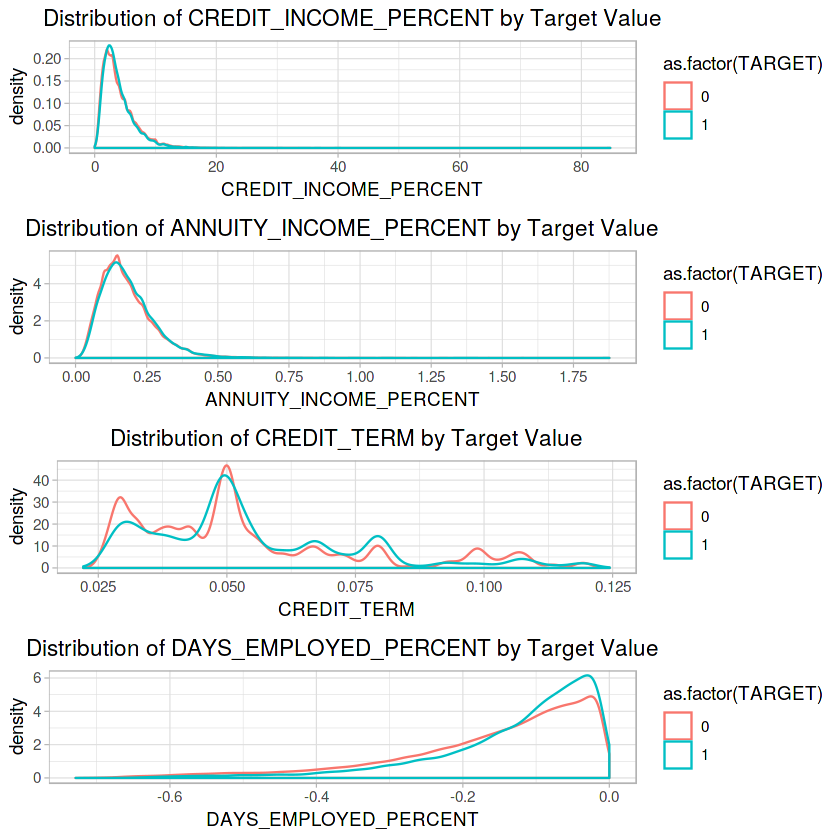

In [60]:
p1=ggplot(train_domain, aes(CREDIT_INCOME_PERCENT,colour=as.factor(TARGET),group=as.factor(TARGET)))+
    geom_density()+
    scale_x_continuous()+
    scale_y_continuous()+
    theme_light() + 
    labs(title = "Distribution of CREDIT_INCOME_PERCENT by Target Value", x = "CREDIT_INCOME_PERCENT")+
    theme(plot.title = element_text(hjust = .5))

p2=ggplot(train_domain, aes(ANNUITY_INCOME_PERCENT,colour=as.factor(TARGET),group=as.factor(TARGET)))+
    geom_density()+
    scale_x_continuous(breaks=seq(0,2,by=0.25))+
    scale_y_continuous()+
    theme_light() + 
    labs(title = "Distribution of ANNUITY_INCOME_PERCENT by Target Value", x = "ANNUITY_INCOME_PERCENT")+
    theme(plot.title = element_text(hjust = .5))

p3=ggplot(train_domain, aes(CREDIT_TERM,colour=as.factor(TARGET),group=as.factor(TARGET)))+
    geom_density()+
    scale_x_continuous()+
    scale_y_continuous()+
    theme_light() + 
    labs(title = "Distribution of CREDIT_TERM by Target Value", x = "CREDIT_TERM")+
    theme(plot.title = element_text(hjust = .5))

p4=ggplot(train_domain, aes(DAYS_EMPLOYED_PERCENT,colour=as.factor(TARGET),group=as.factor(TARGET)))+
    geom_density()+
    scale_x_continuous()+
    scale_y_continuous()+
    theme_light() + 
    labs(title = "Distribution of DAYS_EMPLOYED_PERCENT by Target Value", x = "DAYS_EMPLOYED_PERCENT")+
    theme(plot.title = element_text(hjust = .5))

grid.arrange(p1,p2,p3,p4,nrow=4)

It's hard to say ahead of time if these new features will be useful. The only way to tell for sure is to try them out!

# Baseline

For a naive baseline, we could guess the same value for all examples on the testing set. We are asked to predict the probability of not repaying the loan, so if we are entirely unsure, we would guess 0.5 for all observations on the test set. This will get us a Reciever Operating Characteristic Area Under the Curve (AUC ROC) of 0.5 in the competition (random guessing on a classification task will score a 0.5).

Since we already know what score we are going to get, we don't really need to make a naive baseline guess. Let's use a slightly more sophisticated model for our actual baseline: Logistic Regression.

Logistic Regression Implementation
Here I will focus on implementing the model rather than explaining the details, but for those who want to learn more about the theory of machine learning algorithms, I recommend both An Introduction to Statistical Learning and Hands-On Machine Learning with Scikit-Learn and TensorFlow. Both of these books present the theory and also the code needed to make the models (in R and Python respectively). They both teach with the mindset that the best way to learn is by doing, and they are very effective!

To get a baseline, we will use all of the features after encoding the categorical variables. We will preprocess the data by filling in the missing values (imputation) and normalizing the range of the features (feature scaling). The following code performs both of these preprocessing steps.

In [61]:
train_label = train  %>% select('TARGET')
train = train  %>% select(-'TARGET')

In [62]:
# Median imputation of missing values
train = sapply(train, function(x) ifelse(is.na(x), median(x, na.rm=TRUE), x))  %>% as.data.frame
test = sapply(test, function(x) ifelse(is.na(x), median(x, na.rm=TRUE), x))  %>% as.data.frame

In [63]:
# Scale each feature to 0-1
normalize=function(x){
    return ( (x-min(x)) / max(x)-min(x))
}

train=lapply(train, normalize)  %>% as.data.frame
test=lapply(test, normalize)  %>% as.data.frame

In [64]:
cat("train : (" , nrow(train) , "," , ncol(train) , ")\n")
cat("test : (" , nrow(test) , "," , ncol(test) , ")")

train : ( 307511 , 237 )
test : ( 48744 , 237 )

### Gradient Boosting

In [65]:
train= bind_cols(train_label,train)

In [66]:
train$'TARGET'=as.factor(train$'TARGET')

In [67]:
library(h2o)


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: ‘h2o’

The following objects are masked from ‘package:data.table’:

    hour, month, week, year

The following objects are masked from ‘package:stats’:

    cor, sd, var

The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc



In [68]:
localH2O = h2o.init(ip = "localhost", port = 54321, startH2O = TRUE, max_mem_size = '6g', nthreads = -1)
h2o.train <- as.h2o(train)
h2o.test <-  as.h2o(test)


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/RtmpOEHQxp/h2o_UnknownUser_started_from_r.out
    /tmp/RtmpOEHQxp/h2o_UnknownUser_started_from_r.err


Starting H2O JVM and connecting: .. Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 seconds 358 milliseconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.24.0.3 
    H2O cluster version age:    25 days  
    H2O cluster name:           H2O_started_from_R_root_xfn888 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   5.33 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, Aut

In [69]:
y <- "TARGET"
x <- setdiff(names(h2o.train), y)

In [70]:
set.seed(42)
gbm <- h2o.gbm(x , y , training_frame = h2o.train,
               ntree=100,
               learn_rate=0.01,
               stopping_rounds = 10, 
               stopping_metric = "AUC",
              )

Warning message in .h2o.startModelJob(algo, params, h2oRestApiVersion):
“Dropping bad and constant columns: [DAYS_REGISTRATION, DAYS_ID_PUBLISH, DAYS_EMPLOYED, DAYS_LAST_PHONE_CHANGE].
”

  |======================================================================| 100%


In [71]:
gbm@model$training_metrics@metrics$AUC

[1] 0.7318358

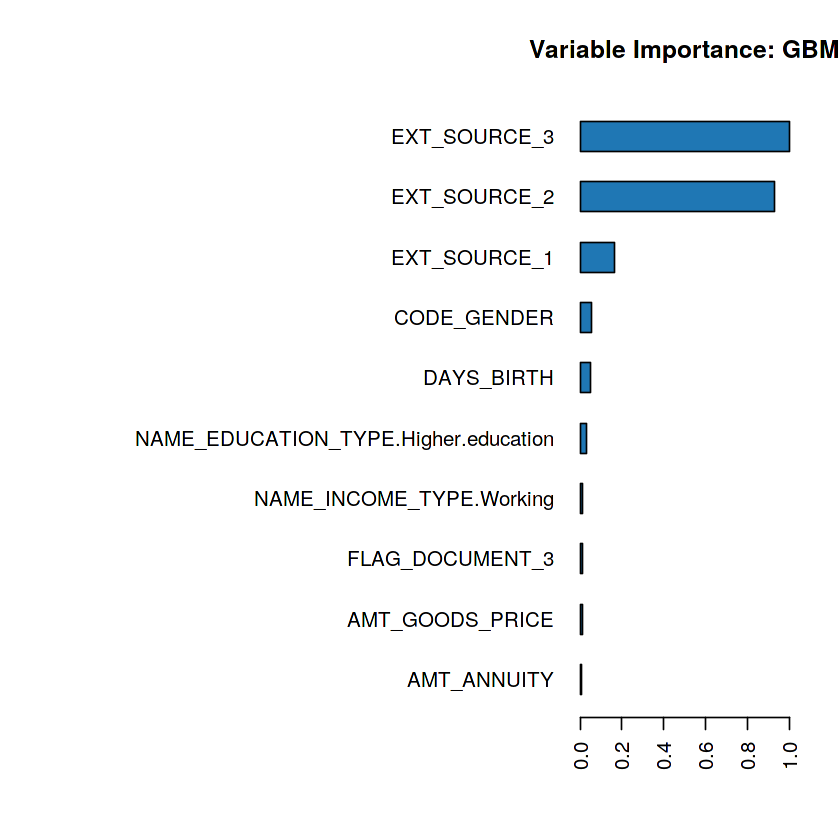

In [72]:
h2o.varimp_plot(gbm, num_of_features = 10)

In [73]:
gbm.pred <- h2o.predict(gbm, h2o.test)

  |======================================================================| 100%


In [74]:
head(gbm.pred)

predict,p0,p1
<fct>,<dbl>,<dbl>
0,0.9261268,0.07387323
0,0.9092828,0.09071718
0,0.9531897,0.04681035
0,0.9465014,0.05349862
0,0.9061774,0.09382261
0,0.9398077,0.06019235


In [75]:
gbm.pred=as.data.frame(gbm.pred)

In [76]:
submission_gbm <- read.csv('../input/sample_submission.csv')
submission_gbm$TARGET <- gbm.pred$p1
write.csv(submission_gbm, file='submission_gbm.csv', row.names = F)